In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow


import pymc3 as pm


from sklearn.datasets import fetch_openml
from sklearn.datasets import fetch_california_housing

#from tensorflow.keras.datasets import california_housing

### 2.3 Bayesian linear regression with PyMC3
In this task you are required to use PyMC3 to perform Bayesian linear regression on the California housing dataset which is easily available via the sklearn.datasets.fetch california housing function. The goal with this dataset is to predict the median house value in a ‘block’ in California. A block is a small geographical area with a population of between 600 and 3000 people. Each datapoint in this dataset corresponds to a block. Consult the scikit-learn documentation for details of the predictor variables.
1. Produce a suitable plot which shows how longitude and latitude affects median house price. Explain what your plot tells you about the relationship between these two predictors and median house price. (5 marks)
2. Decide whether you need to transform and/or clean the data. Justifyyour decision in your report. (5 marks)
3. Choose prior distributions for all model parameters and then use PyMC3to get approximate posterior distributions over each model parameter. In your report include plots of these posterior distributions, as well as giving the mean and standard deviation of each distribution. (5 marks)
4. Did your run of PyMC3 succeed, that is: did it produce good approximations to the desired posterior distributions? Explain your answer.(5 marks)
5. The full dataset has 20640 datapoints. Now run PyMC3 on two random samples of datapoints, one of size 50 and one of size 500. Compare the posterior distributions you get for the 3 dataset sizes (50, 500 and 20640), stating what the most important differences are and explaining how these differences arose. (5 marks)

Without knowledge of the true model parameters, the goal of Bayesian linear regression is to obtain a distribution (posterior) over the model parameters from the data, $P(w_0,w_1,\sigma \vert \mathcal{D})$. First we need to define a prior over the three parameters:

1. $p(w_0) = \mathcal{N}(0, 20)$
2. $p(w_1) = \mathcal{N}(0, 20)$
3. $p(\sigma) = U(0, 20)$

Below is the code to define this model in pymc3. Note that this code performs MCMC using a No U-Turn Sampler (NUTS) which operates using the same principles as the Metropolis algorithm but is much more efficient.

In [21]:
california_housing = fetch_california_housing(as_frame=True)
X = np.array(california_housing.data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(california_housing.data), np.array(california_housing.target),test_size=0.1, random_state=40)
print(X_train.shape); print(X_test.shape)
print(y_train.shape); print(y_test.shape)
print(california_housing.feature_names)

(18576, 8)
(2064, 8)
(18576,)
(2064,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Produce a suitable plot which shows how longitude and latitude affects median house price. 

In [3]:
features_of_interest = ["Longitude", "Latitude"]
california_housing.frame[features_of_interest].describe()
#california_housing.target.describe()

Longitude      Latitude
count  20640.000000  20640.000000
mean    -119.569704     35.631861
std        2.003532      2.135952
min     -124.350000     32.540000
25%     -121.800000     33.930000
50%     -118.490000     34.260000
75%     -118.010000     37.710000
max     -114.310000     41.950000

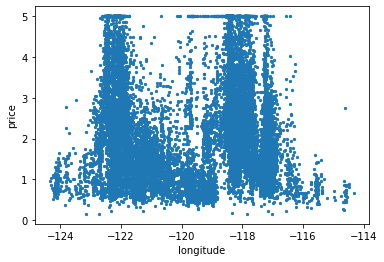

In [9]:
plt.scatter(california_housing.frame["Longitude"], california_housing.target, s=5)
plt.xlabel('longitude')
plt.ylabel('price')
plt.show()

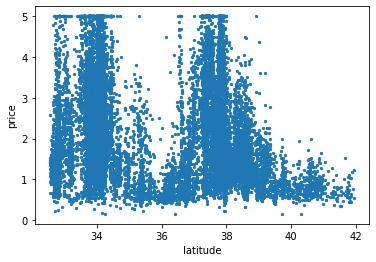

In [5]:
plt.scatter(california_housing.frame["Latitude"], california_housing.target, s=5)
plt.xlabel('latitude')
plt.ylabel('price')
plt.show()

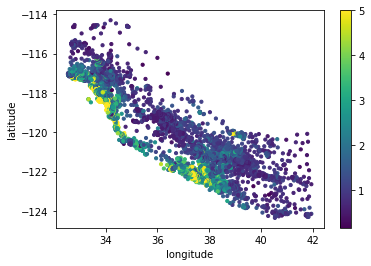

In [65]:
plt.scatter(california_housing.frame["Latitude"], california_housing.frame["Longitude"], c=california_housing.target, s=10, cmap='viridis')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.colorbar()
plt.show()

Decide whether you need to transform and/or clean the data.

In [ ]:
#I haven't used it yet
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
print(X_train.shape); print(y_train.shape)
print(california_housing.frame.info())
print(california_housing.frame.describe())

(18576, 8)
(18576,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154  

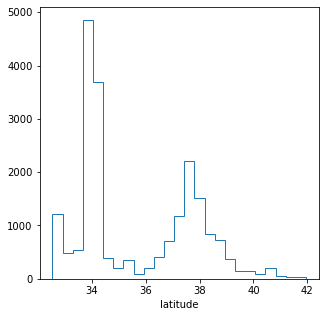

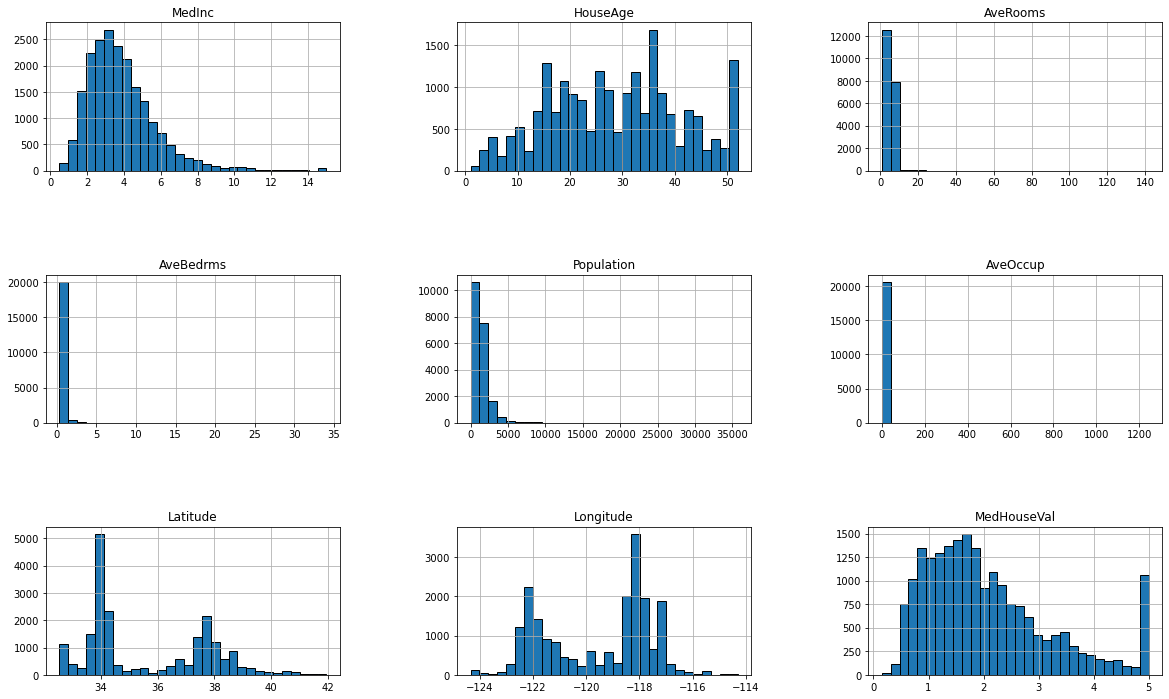

In [18]:
#I plot the histograms of all attributes to see the distribution of values
#I can maybe use this to see which distributions to use for priors? (Normal, gamma, etc.) Idk if this can be done visually
#I might also use this to drop outliers. There are probably better methods though
#scaling and normalising the data hasn't been considered. Doesn't the evidence act as a scaler though?
plt.figure(figsize=(5, 5))
plt.hist(california_housing.frame["Latitude"], 25, histtype='step')
plt.xlabel('latitude')
plt.show()

california_housing.frame.hist(figsize=(20, 12), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)


In [5]:
#correlations
#you can drop the ones with the lowest
from scipy.stats import pearsonr
corr_income, _ = pearsonr(california_housing.frame["MedInc"], california_housing.target)
print('Pearsons correlation- income: %.3f' % corr_income)
corr_age, _ = pearsonr(california_housing.frame["HouseAge"], california_housing.target)
print('Pearsons correlation - house age: %.3f' % corr_age)
corr_pop, _ = pearsonr(california_housing.frame["Population"], california_housing.target)
print('Pearsons correlation - population: %.3f' % corr_pop)
corr_rooms, _ = pearsonr(california_housing.frame["AveRooms"], california_housing.target)
print('Pearsons correlation- rooms: %.3f' % corr_rooms)
corr_bdrms, _ = pearsonr(california_housing.frame["AveBedrms"], california_housing.target)
print('Pearsons correlation - bedrooms: %.3f' % corr_bdrms)
corr_occup, _ = pearsonr(california_housing.frame["AveOccup"], california_housing.target)
print('Pearsons correlation - occupation: %.3f' % corr_occup)
corr_lat, _ = pearsonr(california_housing.frame["Latitude"], california_housing.target)
print('Pearsons correlation- latitude: %.3f' % corr_lat)
corr_lon, _ = pearsonr(california_housing.frame["Longitude"], california_housing.target)
print('Pearsons correlation - longitude: %.3f' % corr_lon)

from scipy.stats import spearmanr
corr_income, _ = spearmanr(california_housing.frame["MedInc"], california_housing.target)
print('Spearmans correlation- income: %.3f' % corr_income)
corr_age, _ = spearmanr(california_housing.frame["HouseAge"], california_housing.target)
print('Spearmans correlation - house age: %.3f' % corr_age)
corr_pop, _ = spearmanr(california_housing.frame["Population"], california_housing.target)
print('Spearmans correlation - population: %.3f' % corr_pop)
corr_rooms, _ = spearmanr(california_housing.frame["AveRooms"], california_housing.target)
print('Spearmans correlation- rooms: %.3f' % corr_rooms)
corr_bdrms, _ = spearmanr(california_housing.frame["AveBedrms"], california_housing.target)
print('Spearmans correlation - bedrooms: %.3f' % corr_bdrms)
corr_occup, _ = spearmanr(california_housing.frame["AveOccup"], california_housing.target)
print('Spearmans correlation - occupation: %.3f' % corr_occup)
corr_lat, _ = spearmanr(california_housing.frame["Latitude"], california_housing.target)
print('Spearmans correlation- latitude: %.3f' % corr_lat)
corr_lon, _ = spearmanr(california_housing.frame["Longitude"], california_housing.target)
print('Spearmans correlation - longitude: %.3f' % corr_lon)

Pearsons correlation- income: 0.688
Pearsons correlation - house age: 0.106
Pearsons correlation - population: -0.025
Pearsons correlation- rooms: 0.152
Pearsons correlation - bedrooms: -0.047
Pearsons correlation - occupation: -0.024
Pearsons correlation- latitude: -0.144
Pearsons correlation - longitude: -0.046
Spearmans correlation- income: 0.677
Spearmans correlation - house age: 0.075
Spearmans correlation - population: 0.004
Spearmans correlation- rooms: 0.263
Spearmans correlation - bedrooms: -0.125
Spearmans correlation - occupation: -0.257
Spearmans correlation- latitude: -0.166
Spearmans correlation - longitude: -0.070


Choose prior distributions for all model parameters and then use PyMC3to get approximate posterior distributions over each model parameter. In your report include plots of these posterior distributions, as well as giving the mean and standard deviation of each distribution.

In [22]:
num_samples = 1000
with pm.Model() as model:
    # Defining our priors
    w0 = pm.Normal('w0', mu=0, sd=20)
    w1 = pm.Normal('w1', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    y_est = w0 + w1*x # auxiliary variables

    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    
    # inference
    sampler = pm.NUTS() # Hamiltonian MCMC with No U-Turn Sampler 
    # or alternatively
    # sampler = pm.Metropolis()
    
    trace = pm.sample(num_samples, sampler, progressbar=True, cores=1, chains=2)
    

TypeError: can't multiply sequence by non-int of type 'FreeRV'

In [23]:
#shuffle
X_train_full, y_train_full = X_train, y_train
X_test_full, y_test_full = X_test, y_test
np.random.seed(42)   #if you want reproducible results set the random seed value.
shuffle_index = np.random.permutation(18576)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
np.random.seed(42)
#not sure if the random permutation num is correct
shuffle_index_test = np.random.permutation(2064)
X_test, y_test = X_test[shuffle_index_test], y_test[shuffle_index_test]
#X_train, y_train = np.random.shuffle((X_train, y_train))

#reduce the dataset
X_train, y_train = X_train[0:1000], y_train[0:1000]
X_test, y_test = X_test[0:200], y_test[0:200]

In [24]:
income = X_train[:,0]
house_age = X_train[:,1]
rooms = X_train[:,2]
bedrooms = X_train[:,3]
population = X_train[:,4]
occup = X_train[:,5]
lat = X_train[:,6]
long = X_train[:,7]

            MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.540000   -124.350000      0.149990  
25%        2.429741     33.930000   -121.800000      1.196000  
50%        2.818116     34.260000   -118.490000      1.797000  
75%        3.282261     37.710000   -118.010000      2.647250  
max     1243.333333     41.950000   -114.310000      5.000010  

In [85]:
#OPTIONS: try a smaller dataset see if the kernel still dies
#try bambi
#figure out mu and sigma
#the prior distributions should probably have diff parameters too: how do I get them?
#posterior = prior x likelihood / evidence
import time
with pm.Model() as model:
    
    # The prior for the model parameters will be a normal distribution
    #how do I get priors that have been observed?
    #I'm assuming I just need to guess the distribution types?
    #do I have to normalize the data for normal distributions?
    #how do I know the mu and stdev?
    
    #income = pm.Normal('income', mu=3.870671, sd=1.899822)
    #rooms = pm.Normal('rooms', mu=5.429000, sd=2.474173)
    #house_age = pm.Normal('house_age', mu=28.639486, sd=12.585558)
    #bedrooms = pm.Normal('bedrooms', mu=1.096675, sd=0.473911)
    #population = pm.Normal('population', mu=1425.476744, sd=1132.462122)
    #occup = pm.Normal('occup', mu=3.070655, sd=10.386050)
    #lat = pm.Normal('lat', mu=35.631861, sd=2.135952)
    #long = pm.Normal('long', mu=-119.569704, sd=2.003532)

    #income = pm.Normal('income', mu=4, sd=2) #observed=data?
    #rooms = pm.Normal('rooms', mu=5, sd=2)
    #house_age = pm.Normal('house_age', mu=29, sd=13)
    #bedrooms = pm.Normal('bedrooms', mu=1, sd=1)
    #population = pm.Normal('population', mu=1425, sd=1132)
    #occup = pm.Normal('occup', mu=3, sd=10)
    #lat = pm.Normal('lat', mu=36, sd=2)
    #long = pm.Normal('long', mu=-120, sd=2)

    income = pm.Normal('income', mu=0, sd=20)
    rooms = pm.Normal('rooms', mu=0, sd=20)
    house_age = pm.Normal('house_age', mu=0, sd=20)
    bedrooms = pm.Normal('bedrooms', mu=0, sd=20)
    population = pm.Normal('population', mu=0, sd=20)
    occup = pm.Normal('occup', mu=0, sd=20)
    lat = pm.Normal('lat', mu=0, sd=20)
    long = pm.Normal('long', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    # Creating the model requires a formula and data (and optionally a family)
    #pm.GLM.from_formula(formula, data = X_train, income = income, rooms = rooms, house_age = house_age)
    #linear model y = w0 + w1x1 + w2x2
    #is the x1, x2 etc the
    #this still kills the kernel
    mu = house_age * X_train[:,1] + rooms * X_train[:,2] + income * X_train[:,0] + bedrooms * X_train[:,3] + population * X_train[:,4] + occup * X_train[:,5] + lat * X_train[:,6] + long * X_train[:,7]
    
    #I need a mu and a sigma
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)
    # Perform Markov Chain Monte Carlo sampling
    sampler = pm.NUTS() # Hamiltonian MCMC with No U-Turn Sampler 
    # or alternatively
    #sampler = pm.Metropolis()
    start = time.time()
    trace = pm.sample(X_train.shape[0], sampler, progressbar=True, cores=1, chains=2, return_inferencedata=True, init="adapt_diag")
    stop = time.time()
    bayes_time = stop-start

Sequential sampling (2 chains in 1 job)
NUTS: [sigma, long, lat, occup, population, bedrooms, house_age, rooms, income]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 123 seconds.


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
income      0.529  0.026   0.484    0.577      0.001    0.001     592.0   
rooms      -0.213  0.037  -0.279   -0.142      0.001    0.001     635.0   
bedrooms    1.319  0.202   0.948    1.701      0.008    0.006     643.0   
house_age   0.018  0.003   0.013    0.023      0.000    0.000    1788.0   
population  0.000  0.000  -0.000    0.000      0.000    0.000    1417.0   
occup      -0.242  0.036  -0.307   -0.172      0.001    0.001    1662.0   
lat        -0.091  0.021  -0.130   -0.052      0.001    0.000     938.0   
long       -0.026  0.007  -0.039   -0.014      0.000    0.000     863.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
income       592.0     612.0    1052.0    1.0  
rooms        630.0     636.0    1053.0    1.0  
bedrooms     643.0     645.0     837.0    1.0  
house_age   1757.0    1791.0    1311.0    1.0  
population  1307.0    1427.0    1316.0    1.0  
occup       1662.0    1670.0    1462

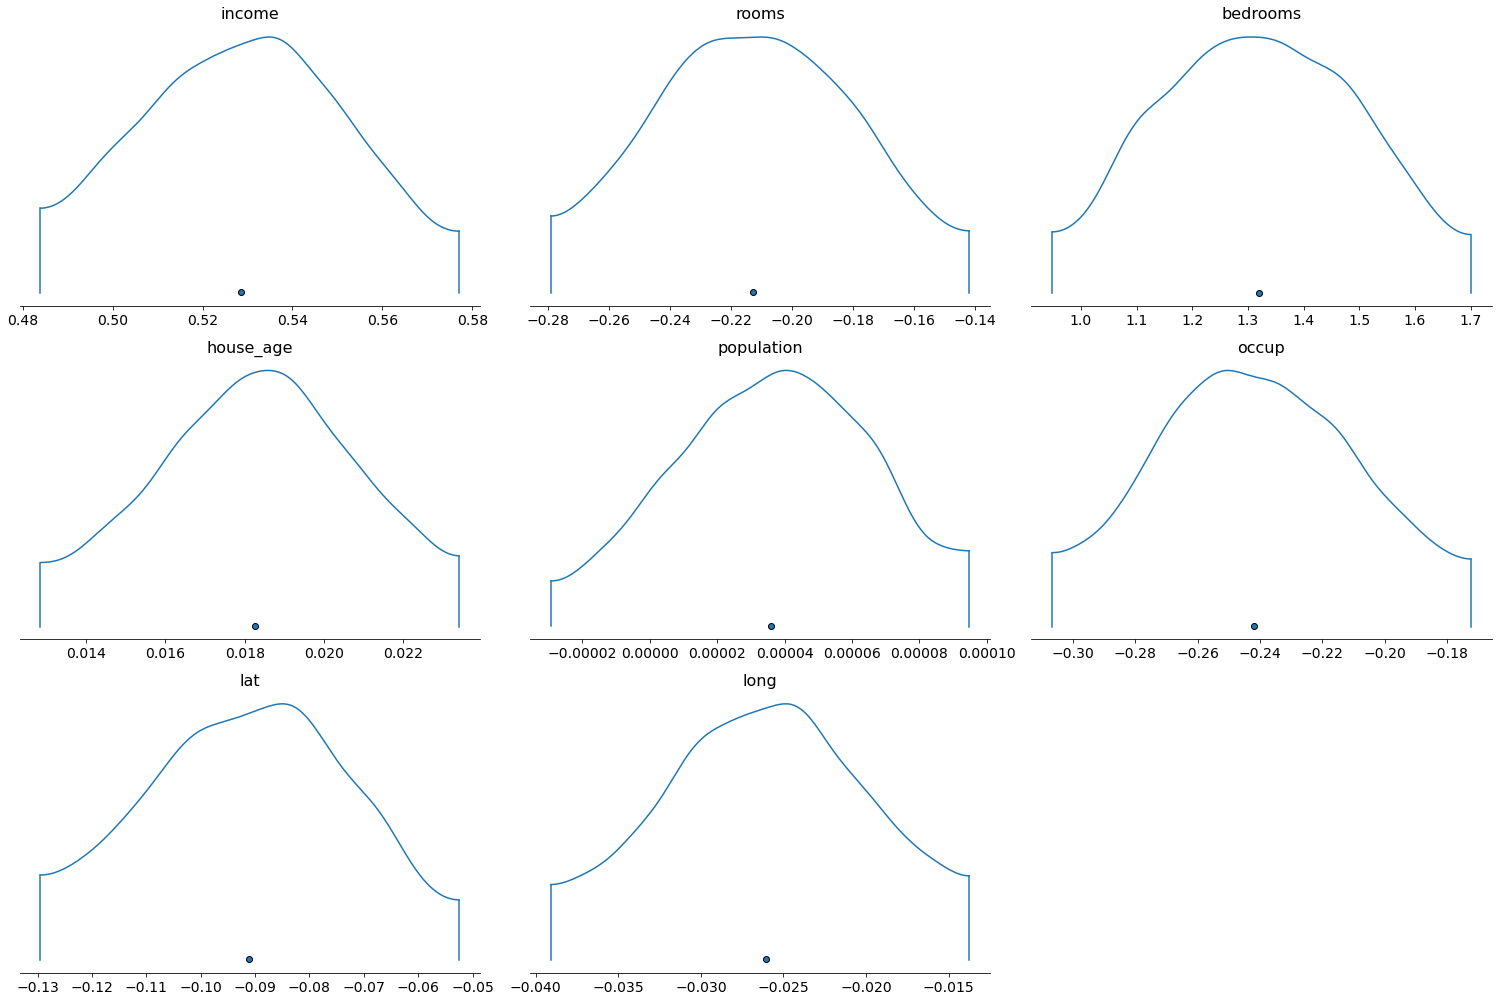

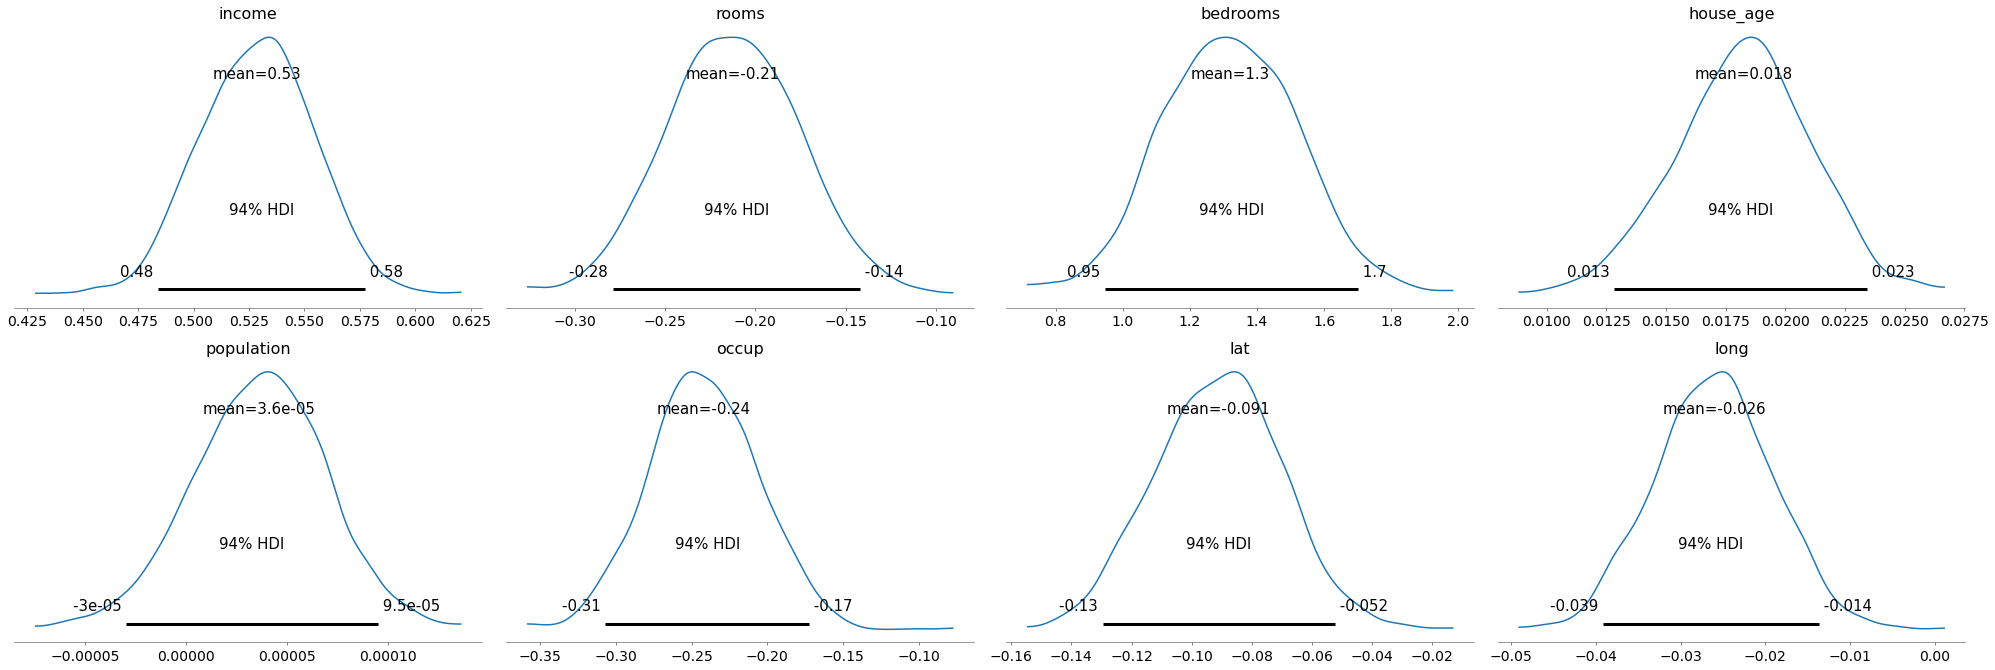

In [89]:
import arviz as az
#all trace plots. They only tell us about the convergence in the markov chain I believe. I need to check documentation tho
with model:
    #pm.traceplot(trace)
    #check autocorrelation
    #pm.autocorrplot(trace)
    #pm.forestplot(trace)
    print(az.summary(trace))
    pm.plots.densityplot(trace)
    az.plot_posterior(trace)

In [36]:
def plot_ppc(smpl):
    posterior_predictive_checks = pm.sample_posterior_predictive(trace, model=model, samples=smpl, progressbar=True)
    y_replicas = [y_rep.mean() for y_rep in posterior_predictive_checks['y']]  


    fig, ax = plt.subplots(1, figsize=(11, 6.5))
    ax.hist(y_replicas, bins=50, alpha=0.5, color="blue", histtype="stepfilled", label="pred")
    ax.hist(y_train_full[0:smpl], bins=50, alpha=0.5, color="yellow", histtype="stepfilled", label="acc")
    ax.axvline(y_train_full[0:smpl].mean(), color="red", label="data")
    ax.axvline(np.array(y_replicas).mean(), color="green", label="pred")
    ax.legend(loc=2)
    ax.set_xlabel("mean price", fontsize=10) 
    ax.set_ylabel("number of datapoints", fontsize=10)
    plt.show()

Did your run of PyMC3 succeed, that is: did it produce good approximations to the desired posterior distributions?

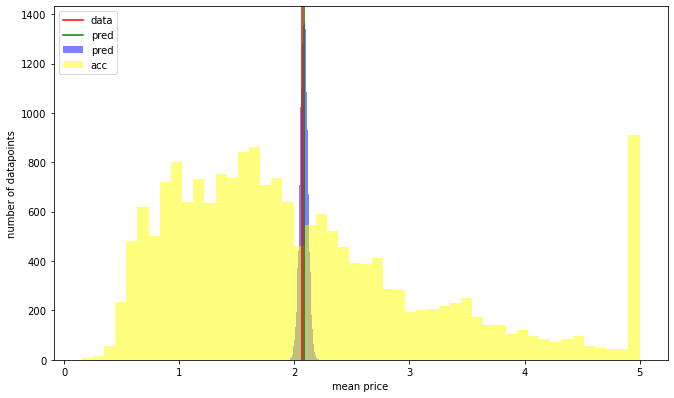

/home/karolina/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


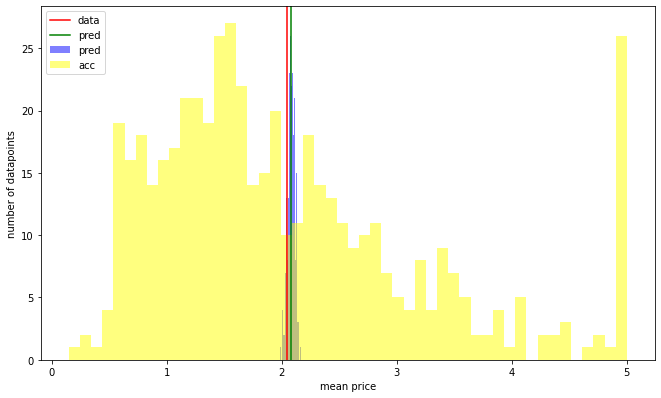

/home/karolina/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


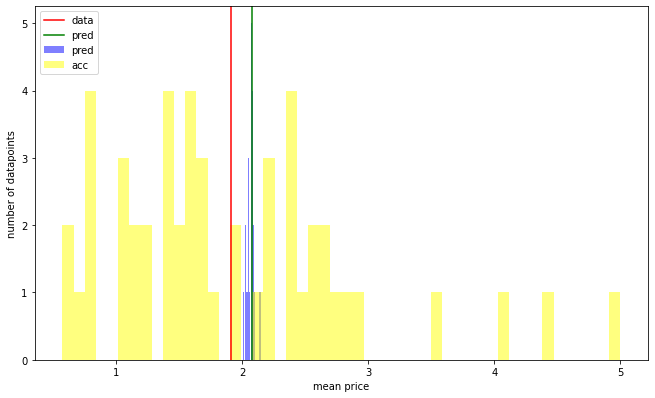

In [37]:
#it can be determined by the predictive check
#it's a very bad prediction
#even the wrong prior distribution choice shouldn't have THAT much of an impact
plot_ppc(20640)
plot_ppc(500)
plot_ppc(50)

In [41]:
#try to plot the posteriors over each parameter
#it could be compared to the priors of the parameters
print(trace['income'])
plt.figure(figsize=(5, 5))
plt.hist(trace['income'], 25, histtype='step')
plt.xlabel('income')
plt.show()

KeyError: income ~ Normal

 The full dataset has 20640 datapoints. Now run PyMC3 on two random samples of datapoints, one of size 50 and one of size 500. Compare the posterior distributions you get for the 3 dataset sizes (50, 500 and 20640), stating what the most important differences are and explaining how these differences arose.

In [ ]:
#the larger the dataset size the closer the real and predictive means: bayes needs large samples

### 2.4 Trees and ensembles
This part extends the work on decision trees and ensemble methods from lab 7 to regression on the California Housing regression task.

### 2.4.1 CART Decision Trees
In this part you are going to apply a decision tree regressor to the California
housing dataset and analyse its behaviour. Your answers should address the
following points:
1. Briefly explain how the CART decision tree method works. (2 marks)
2. Use model selection to optimise the hyperparameters of the model. Which hyperparameter has the strongest effect on the model’s performance? Use a plot to show this effect. (5 marks)
3. How do the hyperparameters affect the training time? Use plots to support your discussion. Explain how this affects your choice of hyperparameter values. (3 marks)
4. What are the results for your chosen setup on the test set? Interpret and discuss your results. (3 marks)
5. Visualise the tree (or part of the tree) and use the visualisation to identify the most important features. (2 marks)

For a given dataset of input-output pairs, there are a number of ways to construct a decision tree that can accurately classify the set of examples. We will be using the implementation of decision trees from the scikit-learn library which uses the CART (Classification And Regression Tree) algorithm with the Gini impurity criterion (see this for simple explanation of Gini impurity). This algorithm can be summarised as follows:

1. Obtaining the root node: Test the possible splits of the dataset using conditions involving each of the input features and measure the Gini impurity of each split. The root node is given by the split that minimises the weighted sum of the Gini impurities of the two branches. The weights are equal to the number of data points that satisfy the condition of the corresponding branch.
2. Creating the remaining decision nodes: Iteratively follow the same process as step 1 using only the data points that match the conditions necessary to reach this point in the tree.
3. Creating the Leaf nodes: These nodes are created when one of the stopping criteria is met. This set of criteria includes the case where all points of each class have been completely separated by a split (i.e. when the impurity is 0) or when some maximum depth has been reached.


In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

import graphviz

Use model selection to optimise the hyperparameters of the model. Which hyperparameter has the strongest effect on the model’s performance? Use a plot to show this effect. 

In [6]:
dataset = X #np.array(california_housing.data)
X_feature_names = california_housing.feature_names
y = np.array(california_housing.target)
#y_target_names = california_housing.target_names

# 60% training, 20% dev and 20% test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.25)
print(X_train.shape); print(X_test.shape)
print(y_train.shape); print(y_test.shape)

(12384, 8)
(4128, 8)
(12384,)
(4128,)


In [7]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

print("Training set accuracy: {}".format(tree_model.score(X_train, y_train)))
print("Test set accuracy: {}".format(tree_model.score(X_test, y_test)))

Training set accuracy: 1.0
Test set accuracy: 0.5613013680673035


In [8]:
from sklearn.metrics import mean_squared_error
prediction = tree_model.predict(X_train)
print(mean_squared_error(y_train, prediction))

6.726720897233434e-32


In [75]:
#Normalized total reduction of criteria by feature (Gini importance).

#min_samples_split - Minimum samples for a node split
#min_samples_leaf - Minimum samples for a terminal node (leaf)
#max_depth - Maximum depth of the tree (vertical depth)
#max_features - Maximum features to consider for a split

#min_weight_fraction_leaffloat, default=0.0
#The minimum weighted fraction of the sum total of weights (of all the input samples) 
#required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

#max_leaf_nodesint, default=None
#Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. 
#If None then unlimited number of leaf nodes.

#min_impurity_decreasefloat, default=0.0
#A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

#ccp_alphanon-negative float, default=0.0
#Complexity parameter used for Minimal Cost-Complexity Pruning. 
#The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. 
#By default, no pruning is performed.

from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [2, 3, 5, 10, 20, 50, 100, 1000],
    'min_samples_split': [5, 10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [1, 2 , 3, 4, 5, 6, 7, 8],
    #'max_leaf_nodesint': [2, 3, 5, 10, 20, 50, 100, 1000],
    #'min_impurity_decreasefloat': [2, 3, 5, 10, 20, 50, 100, 1000],

}

clf = GridSearchCV(tree_model, param_grid, cv = 5, scoring='r2', verbose = 2, n_jobs=-1)
# perform search
clf.fit(X_train, y_train)

# best estimator
params = clf.best_params_
best_score = clf.best_score_
print(params)
print(best_score)
print (clf.score(X_train,y_train))
print (clf.score(X_test,y_test))


Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.2s


{'max_depth': 20, 'max_features': 6, 'min_samples_leaf': 10, 'min_samples_split': 20}
0.6005948268782788
0.7843910909456226
0.6298857028890609


[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:    7.9s finished


In [77]:
#it's overfitting a lot less now!
tree_model = DecisionTreeRegressor(max_depth = 20, min_samples_leaf = 10, min_samples_split = 50)
tree_model.fit(X_train, y_train)

print("Training set accuracy: {}".format(tree_model.score(X_train, y_train)))
print("Test set accuracy: {}".format(tree_model.score(X_test, y_test)))
print(tree_model.feature_importances_)

Training set accuracy: 0.7205282867057277
Test set accuracy: 0.6439054146296591
[0.67924778 0.06902277 0.         0.01590031 0.00287555 0.13575302
 0.0426344  0.05456618]


In [33]:
#get hyperparameter importances
#plot the relation between the most important one and the model's performance (validation curve?)
from sklearn.model_selection import validation_curve
def plot_validation_curve(model, X, y, param_range, param_name):
    train_scores, test_scores = validation_curve(estimator=model,
                                             X=X, y=y,
                                             cv=5,
    param_name=param_name, param_range=param_range)
#
# Find the mean of training and test scores out of 10-fod StratifiedKFold cross validation run as part fo execution of validation curve
#
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
#
# Plot the model scores (accuracy) against the paramater range
#
    plt.plot(param_range, train_mean,
             marker='o', markersize=5,
             color='blue', label='Training Accuracy')
    plt.plot(param_range, test_mean,
             marker='o', markersize=5,
             color='green', label='Validation Accuracy')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()

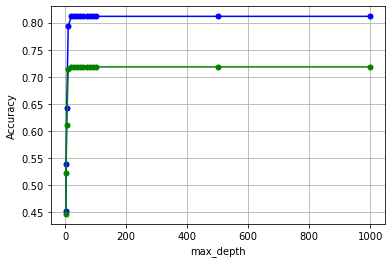

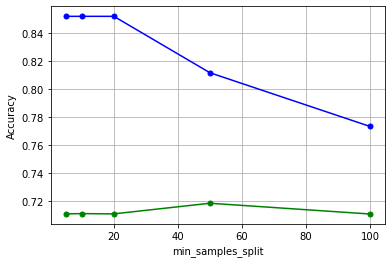

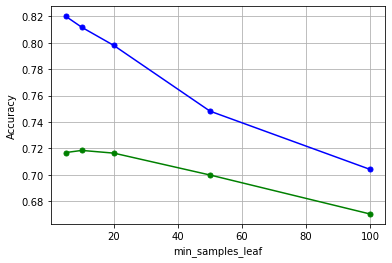

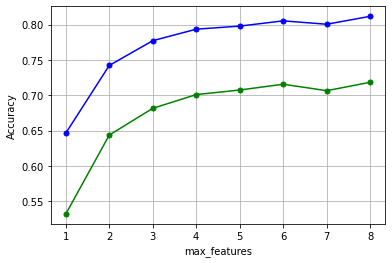

In [135]:
#it appesars max depth has the strongest effect
max_depth_range = [2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000]
plot_validation_curve(tree_model, X_train, y_train, max_depth_range, 'max_depth')
min_samples_split_range = [5, 10, 20, 50, 100]
plot_validation_curve(tree_model, X_train, y_train, min_samples_split_range, 'min_samples_split')
min_samples_leaf_range = [5, 10, 20, 50, 100]
plot_validation_curve(tree_model, X_train, y_train, min_samples_leaf_range, 'min_samples_leaf')
max_features = [1, 2 , 3, 4, 5, 6, 7, 8]
plot_validation_curve(tree_model, X_train, y_train, max_features, 'max_features')

How do the hyperparameters affect the training time? Use plots to support your discussion. Explain how this affects your choice of hyperparameter values.

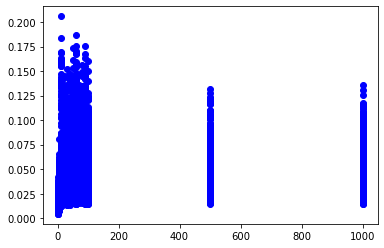

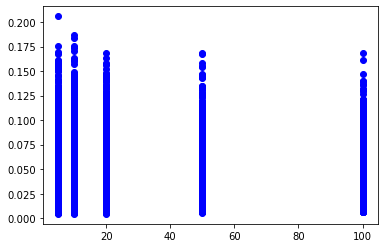

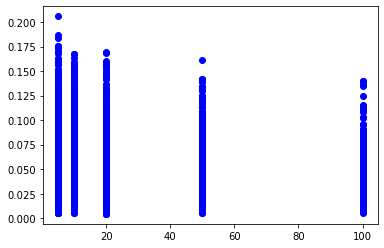

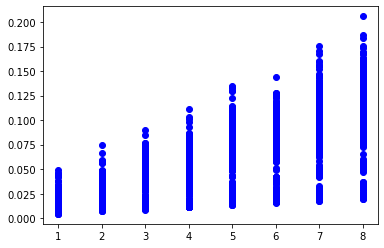

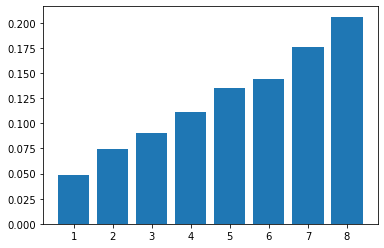

In [140]:
plt.scatter(clf.cv_results_['param_max_depth'].data, clf.cv_results_['mean_fit_time'],
             c='blue')
plt.show()
plt.scatter(clf.cv_results_['param_min_samples_split'].data, clf.cv_results_['mean_fit_time'],
             c='blue')
plt.show()
plt.scatter(clf.cv_results_['param_min_samples_leaf'].data, clf.cv_results_['mean_fit_time'],
             c='blue')
plt.show()
plt.scatter(clf.cv_results_['param_max_features'].data, clf.cv_results_['mean_fit_time'],
             c='blue')
plt.show()

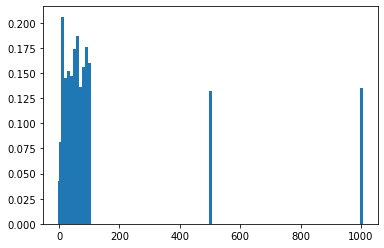

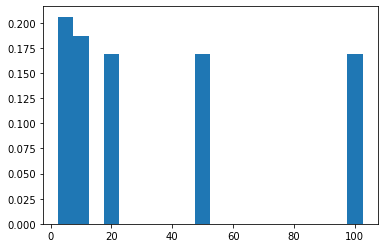

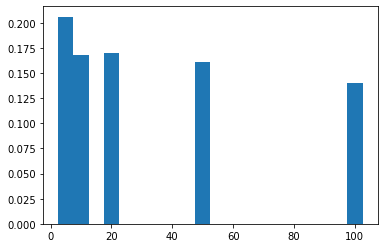

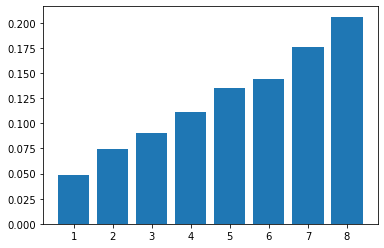

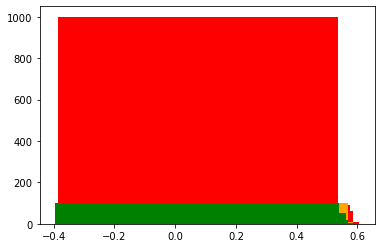

In [145]:
plt.bar(clf.cv_results_['param_max_depth'].data, clf.cv_results_['mean_fit_time'], width = 10)
plt.show()
plt.bar(clf.cv_results_['param_min_samples_split'].data, clf.cv_results_['mean_fit_time'], width = 5)
plt.show()
plt.bar(clf.cv_results_['param_min_samples_leaf'].data, clf.cv_results_['mean_fit_time'], width = 5)
plt.show()
plt.bar(clf.cv_results_['param_max_features'].data, clf.cv_results_['mean_fit_time'])
plt.show()
plt.bar(clf.cv_results_['mean_fit_time'], clf.cv_results_['param_max_features'].data, color = 'blue')
plt.bar(clf.cv_results_['mean_fit_time'], clf.cv_results_['param_max_depth'].data, color = 'red')
plt.bar(clf.cv_results_['mean_fit_time'], clf.cv_results_['param_min_samples_split'].data, color = 'orange')
plt.bar(clf.cv_results_['mean_fit_time'], clf.cv_results_['param_min_samples_leaf'].data, color = 'green')
plt.show()

What are the results for your chosen setup on the test set?

In [12]:
print("Training set accuracy: {}".format(tree_model.score(X_train, y_train)))
print("Test set accuracy: {}".format(tree_model.score(X_test, y_test)))

Training set accuracy: 0.8071937274289906
Test set accuracy: 0.711247346773619


Visualise the tree (or part of the tree) and use the visualisation to identify the most important features.

[0.60015599 0.04764974 0.0129785  0.00595546 0.00943906 0.14179276
 0.09139072 0.09063777]


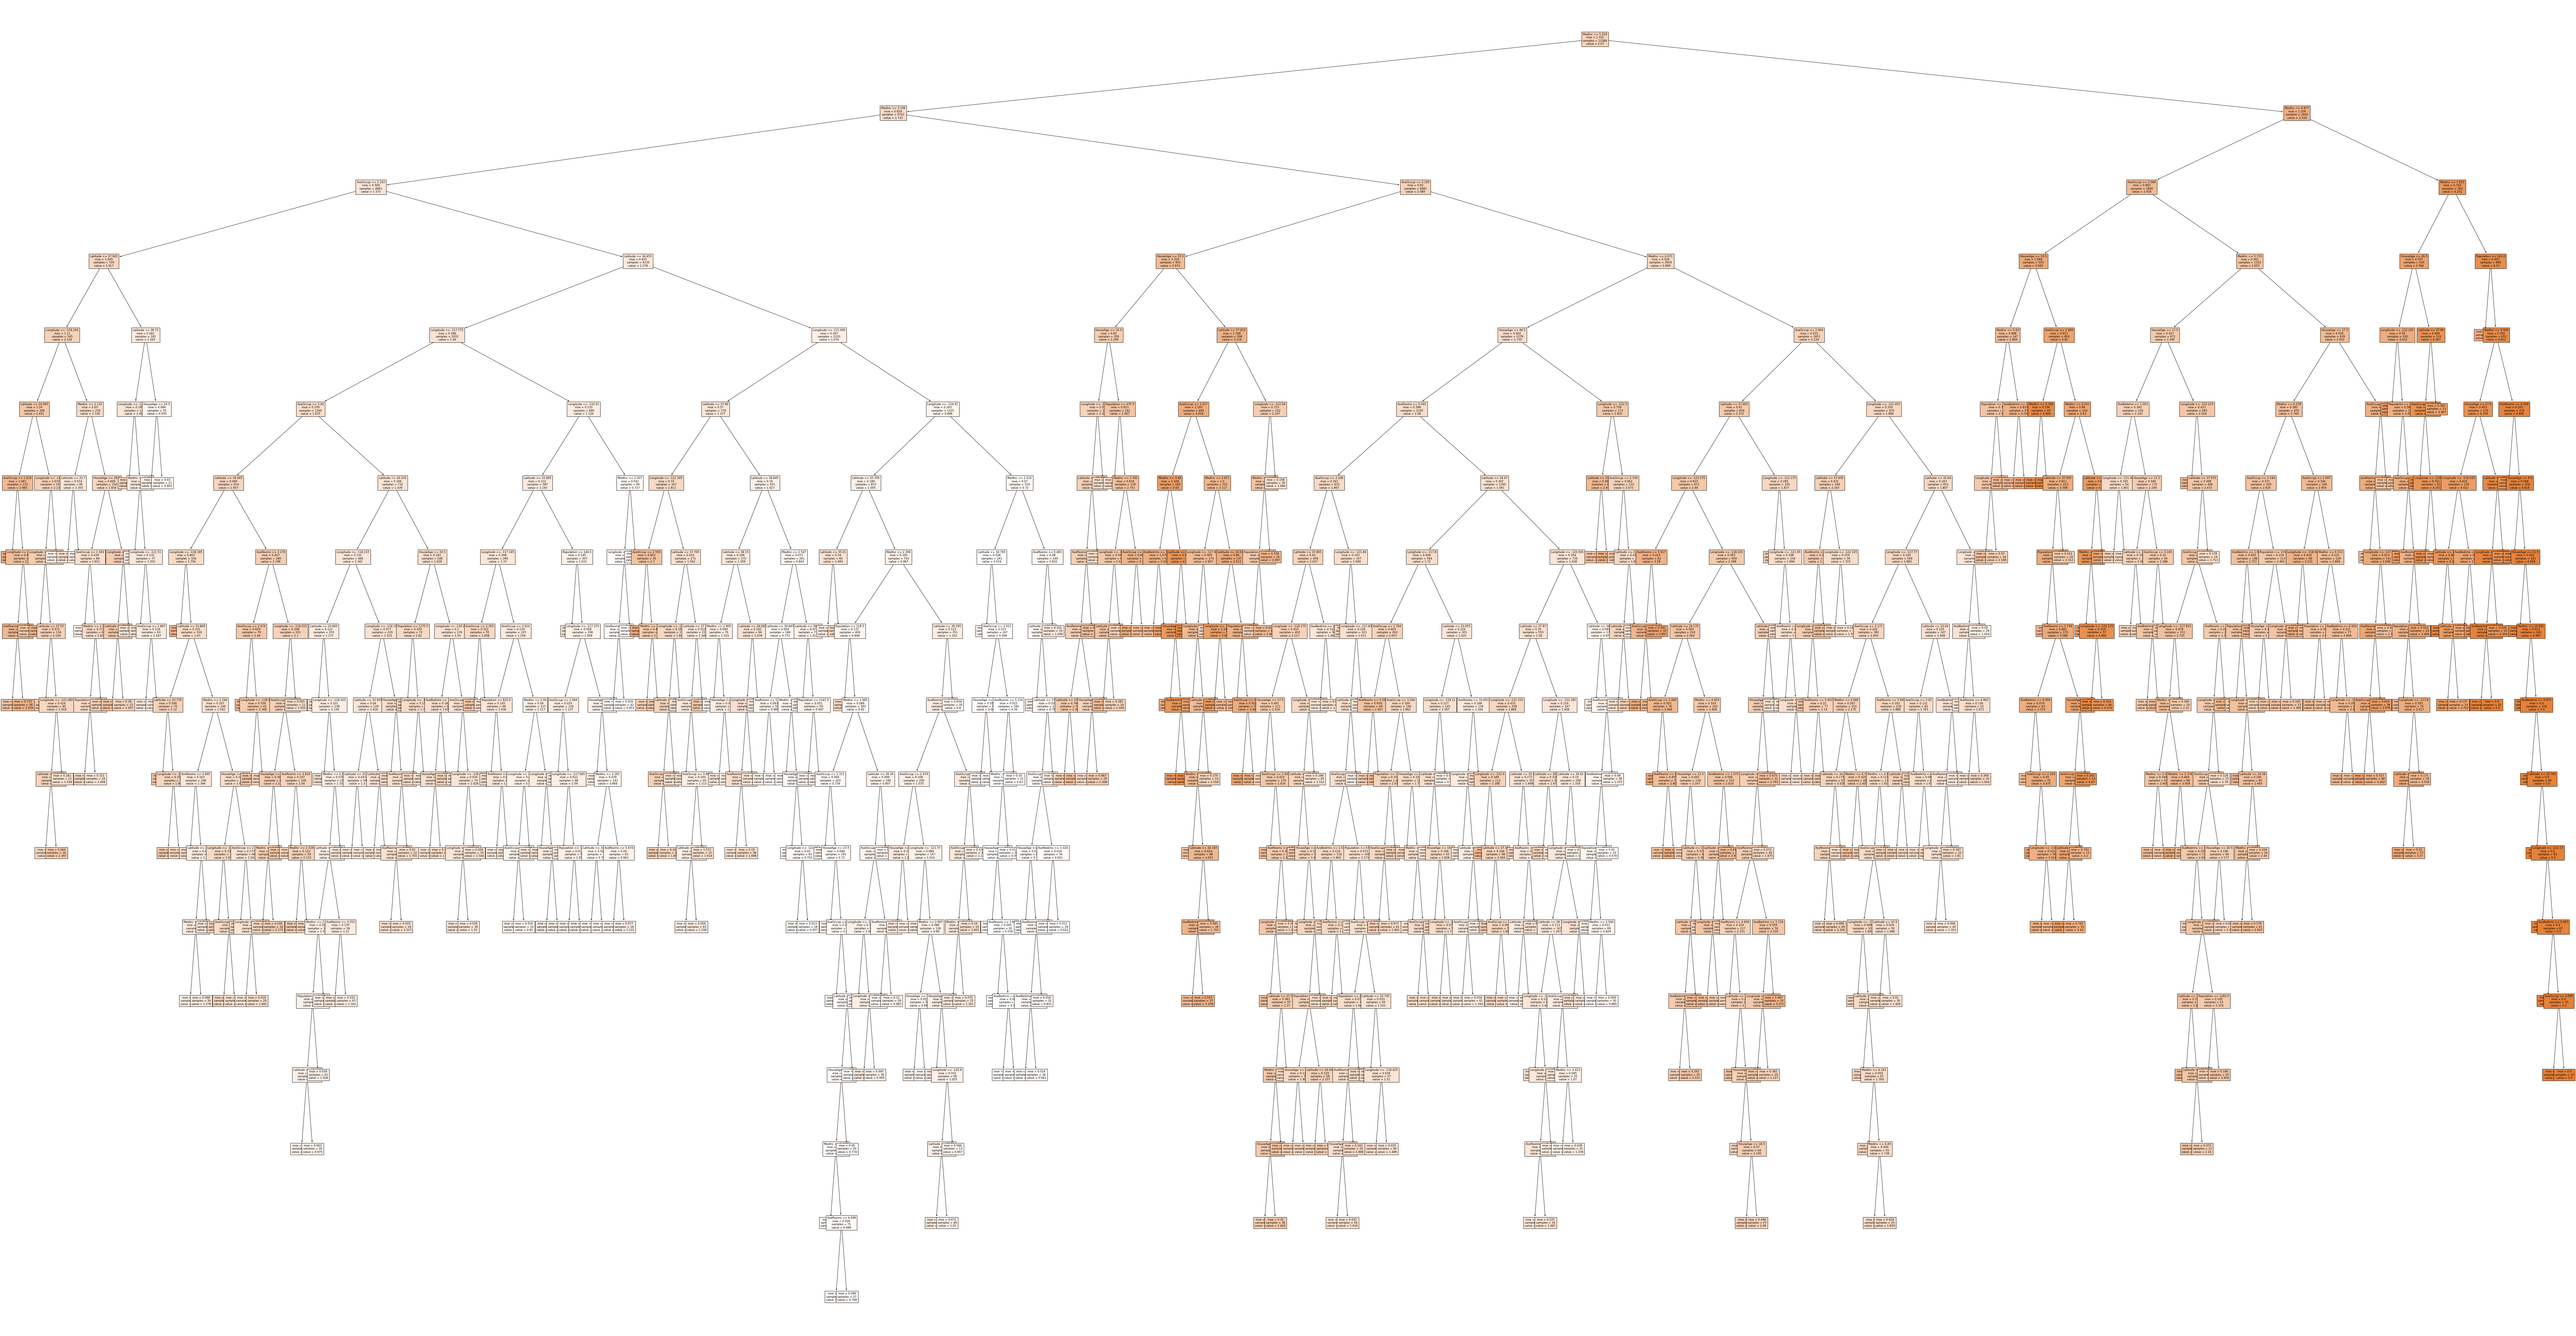

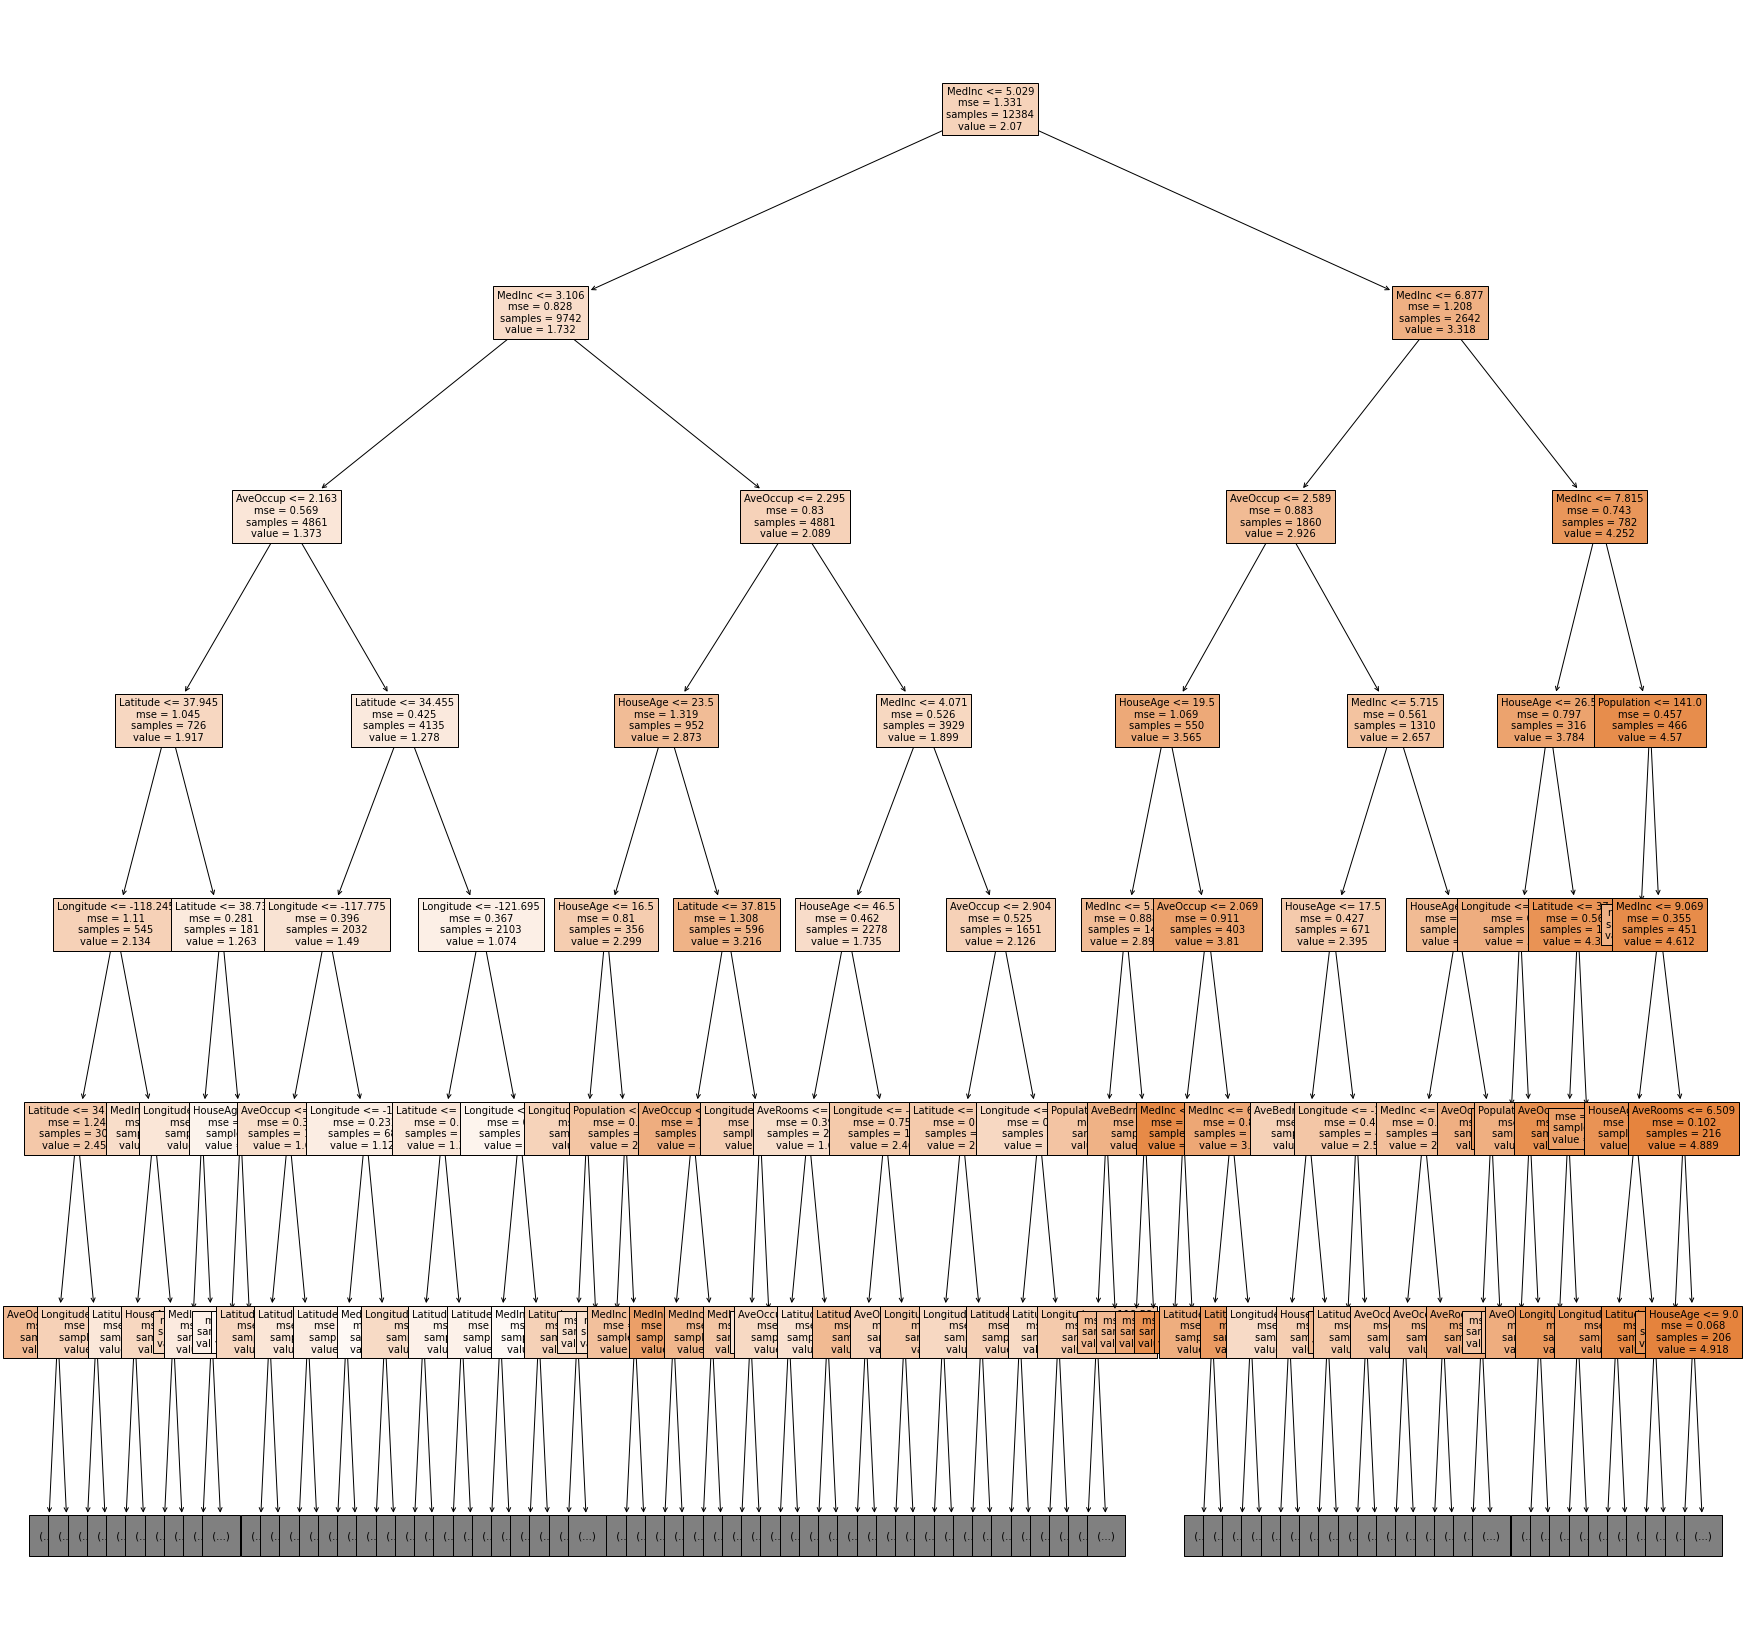

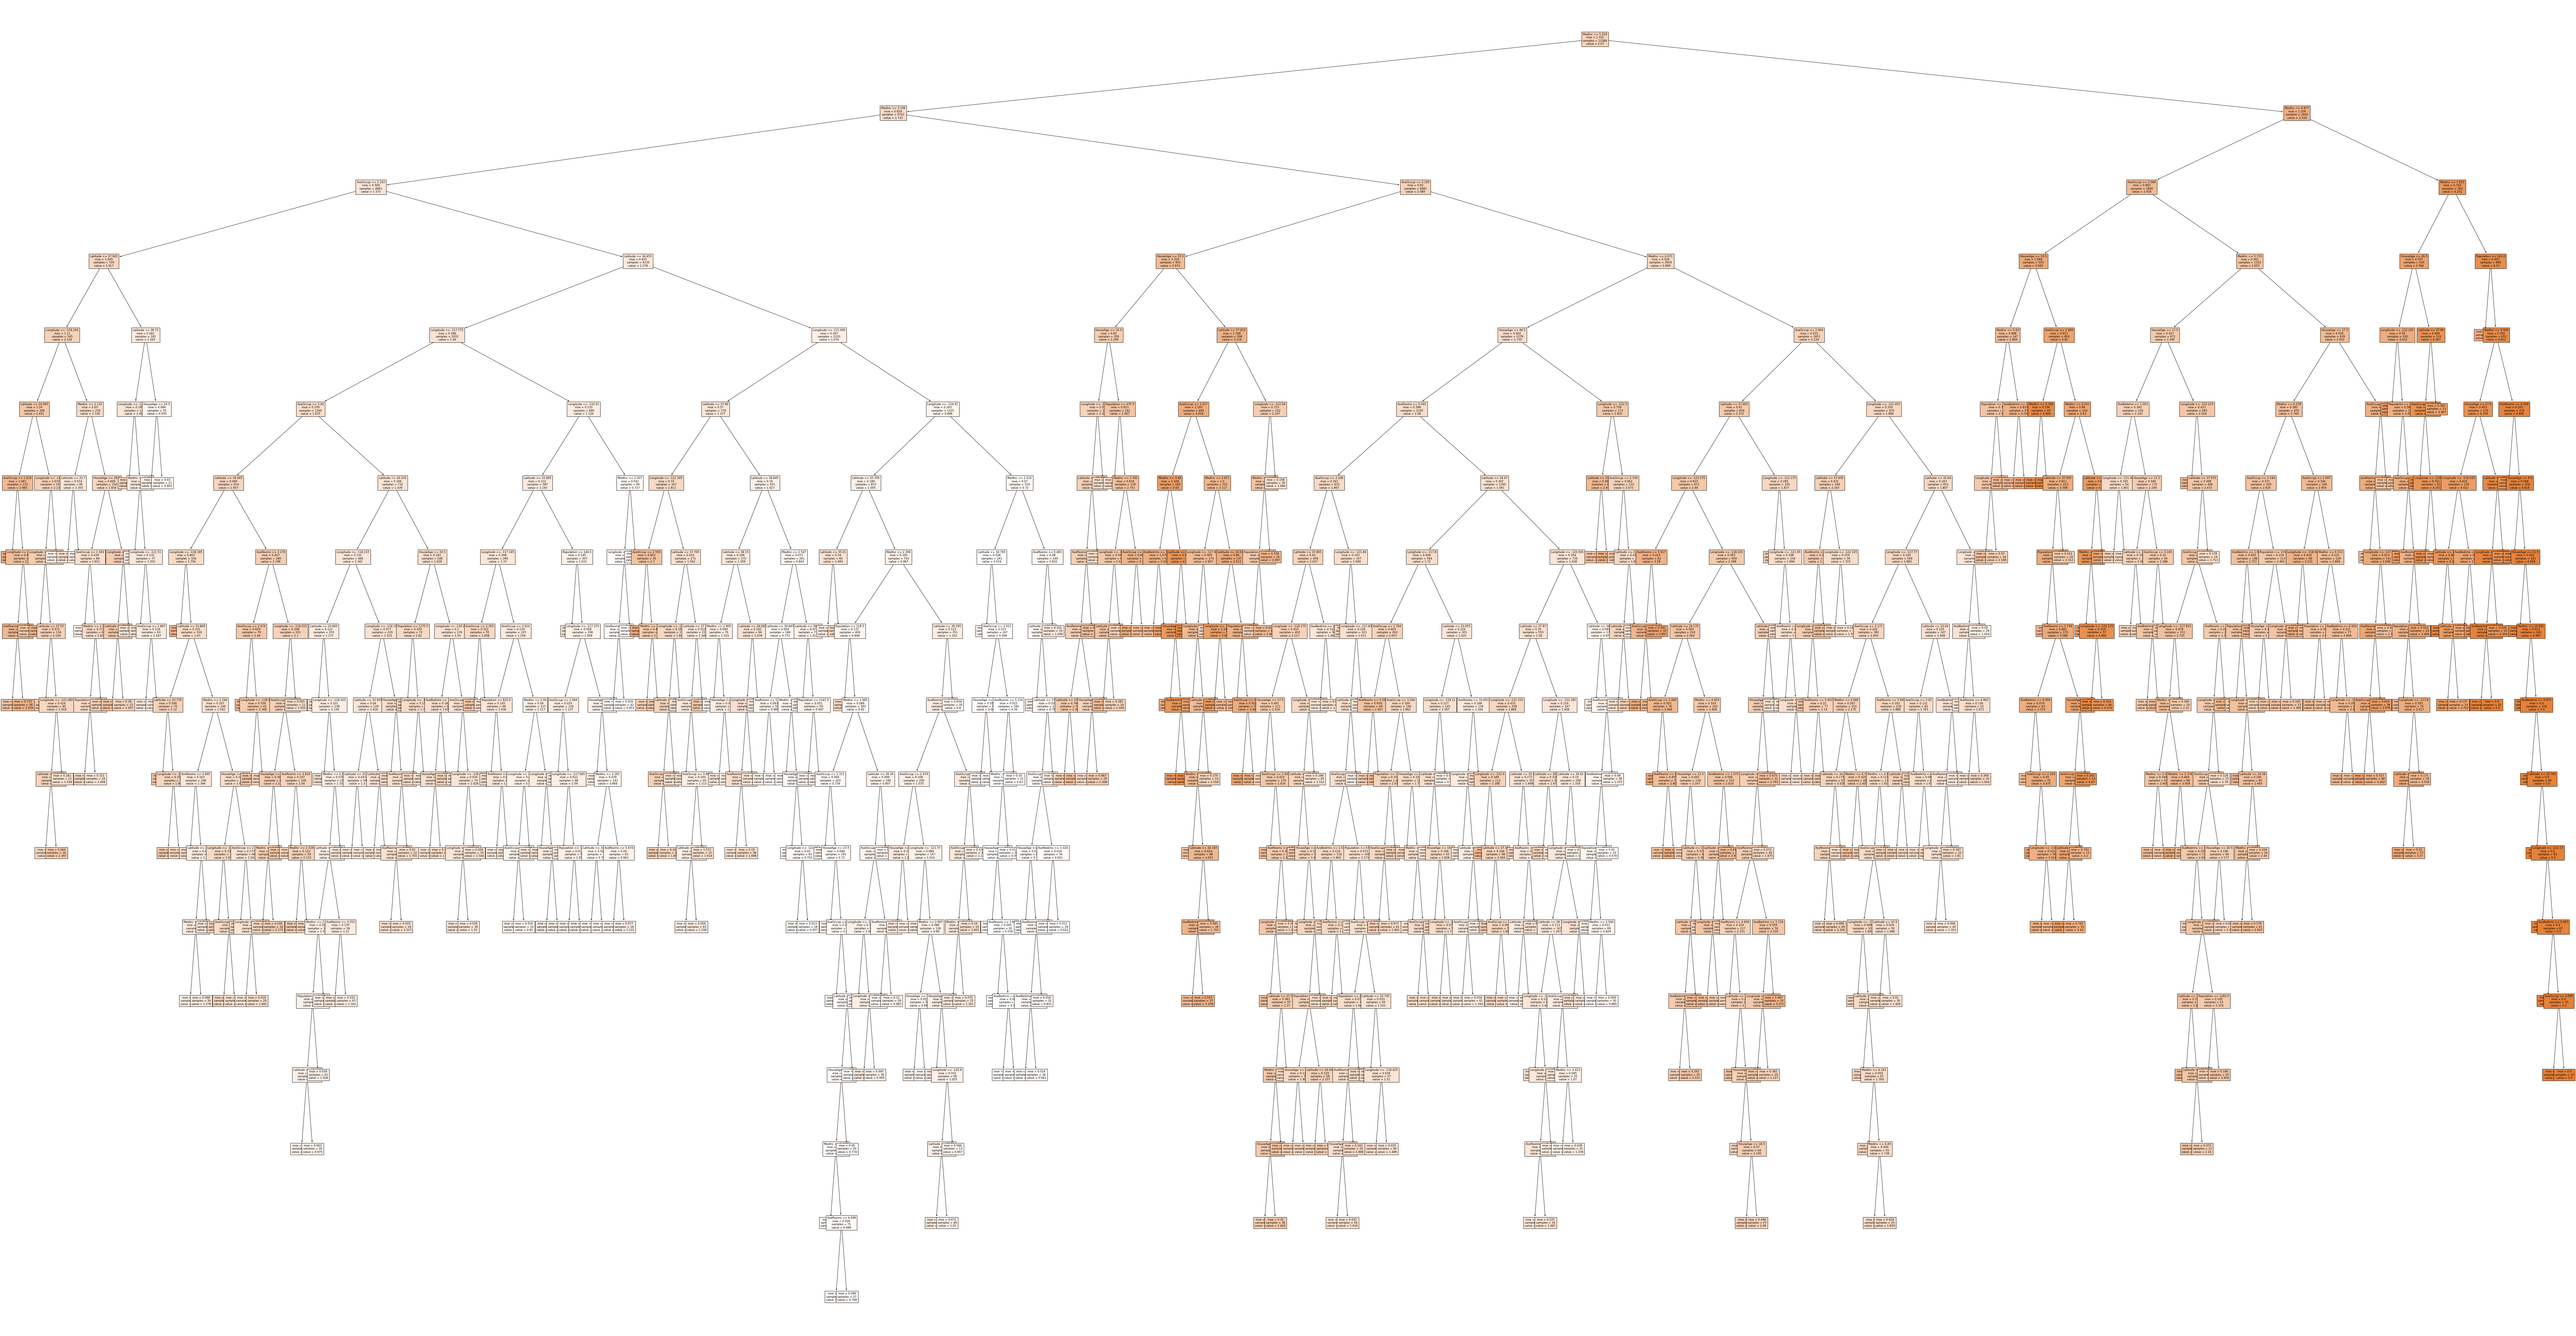

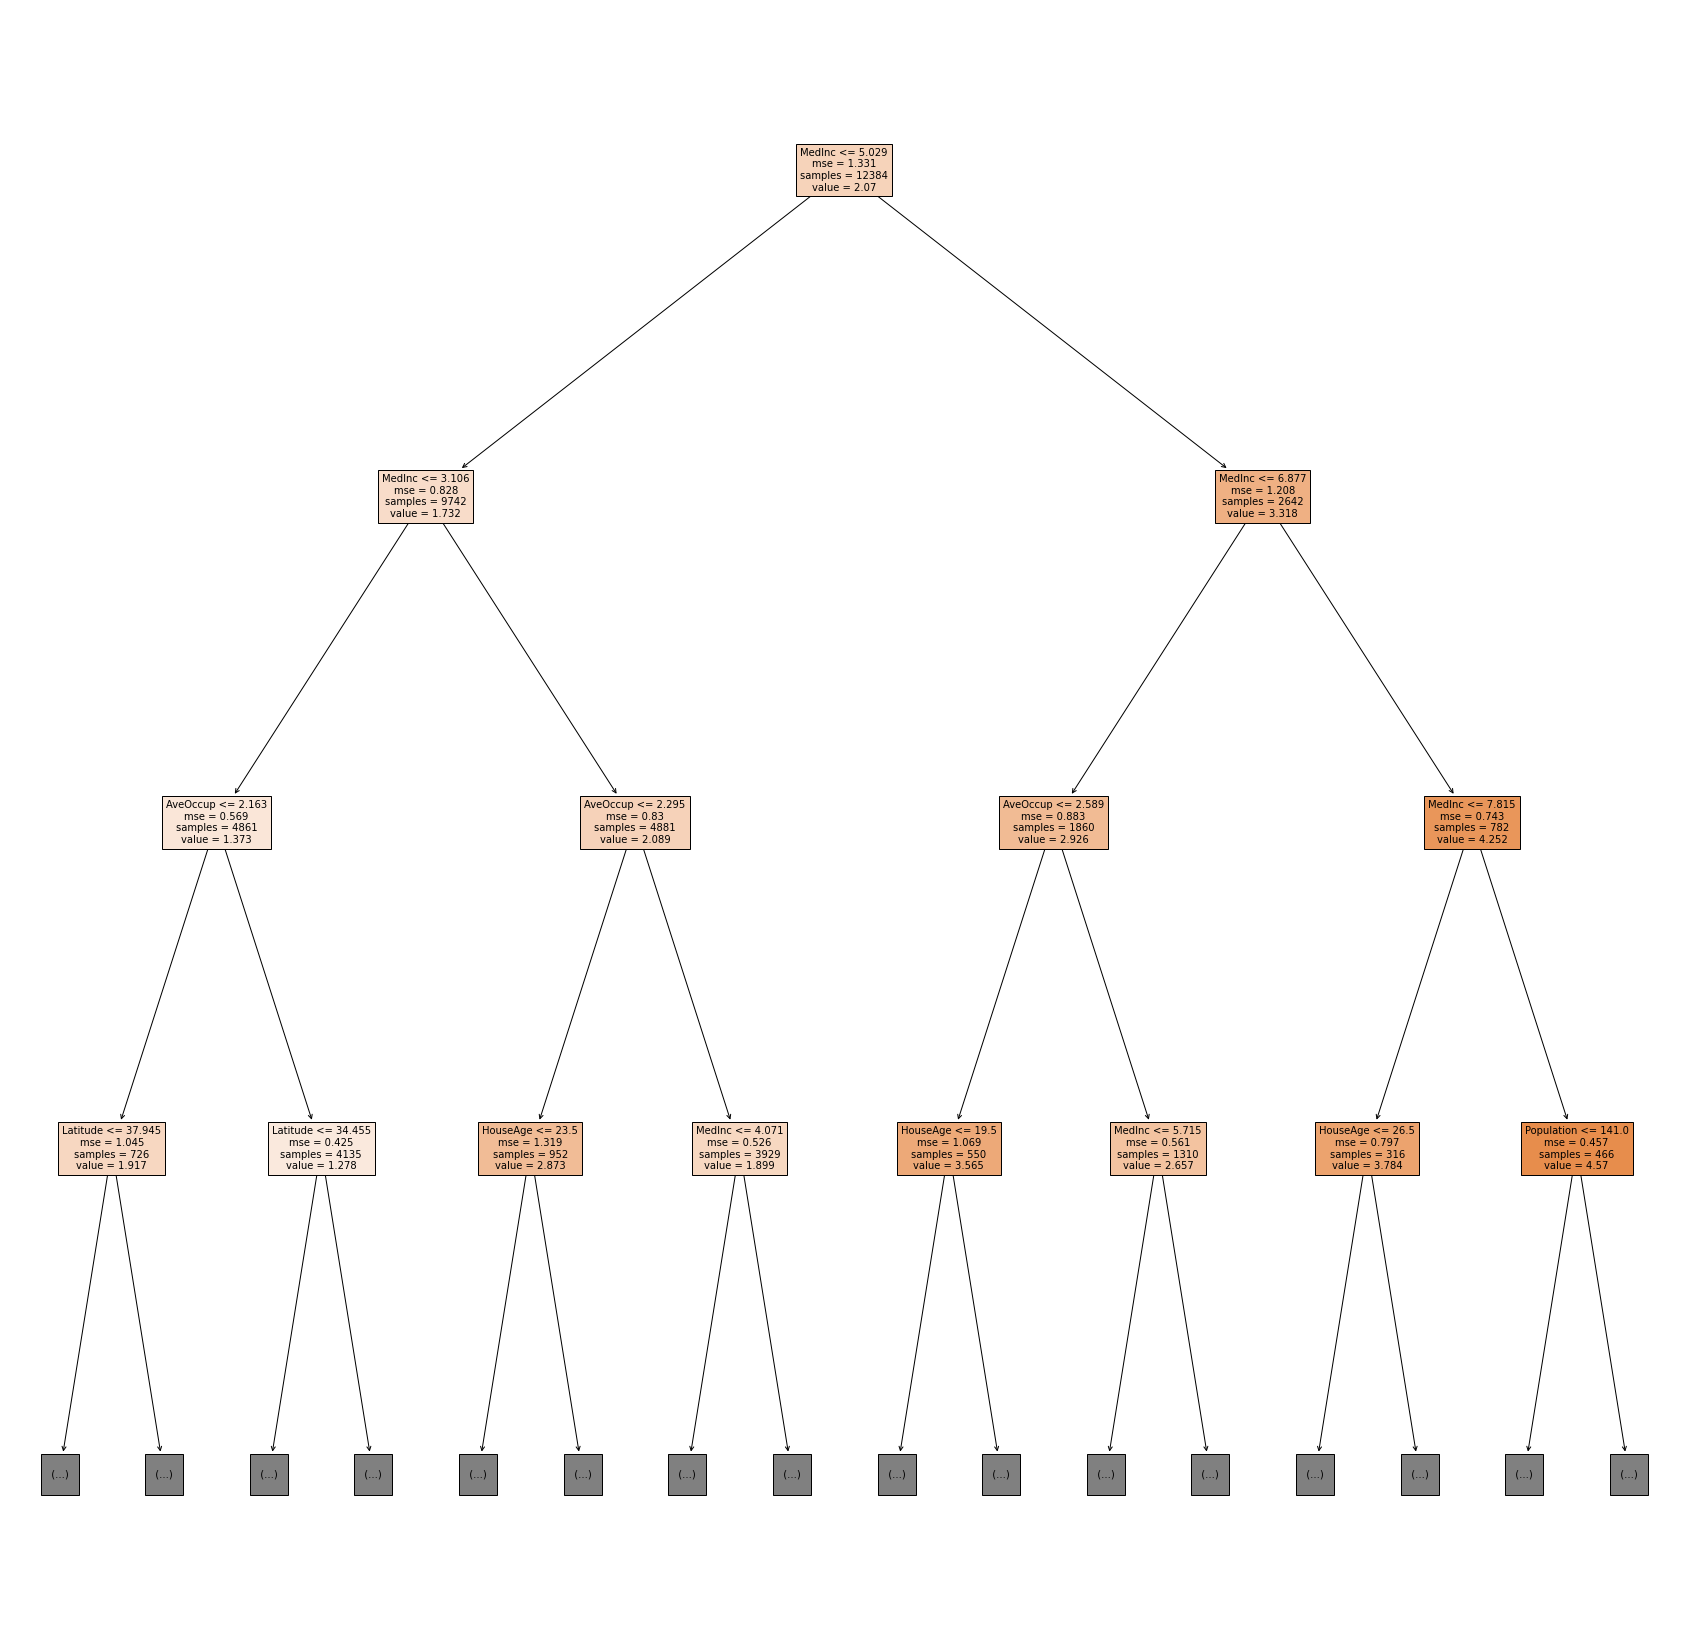

In [148]:
import graphviz
from sklearn import tree

print(tree_model.feature_importances_)

text_representation = tree.export_text(tree_model)
#print(text_representation)
fig = plt.figure(figsize=(150,80))
_ = tree.plot_tree(tree_model, feature_names=X_feature_names, filled=True, fontsize = 9)
fig = plt.figure(figsize=(30,30))
_ = tree.plot_tree(tree_model, feature_names=X_feature_names, filled=True, fontsize = 10, max_depth = 6)
#from dtreeviz.trees import dtreeviz # remember to load the package

#    it shows the distribution of decision feature in the each node (nice!)
#    it shows the class-color matching legend
#    it shows the distribution of the class in the leaf in case of classification tasks, and mean of the leaf’s reponse in the case of regression tasks

#viz = dtreeviz(model, X_train, y_train,
#                target_name="target",
#                feature_names=X_feature_names)
#viz
fig = plt.figure(figsize=(150,80))
_ = tree.plot_tree(tree_model, feature_names=X_feature_names, filled=True, fontsize = 9)
fig = plt.figure(figsize=(30,30))
_ = tree.plot_tree(tree_model, feature_names=X_feature_names, filled=True, fontsize = 10, max_depth = 3)
#income is the most important

### 2.4.2 Random Forests
Here, you will apply a random forest regressor to the California housing
dataset and compare its behaviour with other methods. Your answers should
address the following points:
1. Briefly explain how random forests work. (2 marks)
2. Determine a suitable number of base models for your random forest.
Justify your choice. (2 marks)
3. What are the results for your chosen setup on the test set? Interpret
and discuss your results. (3 marks)
4. Compare your results for the random forest with those of the single
decision tree and Bayesian Linear Regression, considering both per-
formance and training time. Use a table or suitable plot to show the
comparison and discuss the reasons for the differences. (3 marks)

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

Determine a suitable number of base models for your random forest. 

In [48]:
regressor = RandomForestRegressor(n_estimators = 800, random_state = 0)
regressor.fit(X_train, y_train)
#validation curve and gridcv?

RandomForestRegressor(n_estimators=800, random_state=0)

In [15]:
print("Training set accuracy: {}".format(regressor.score(X_train, y_train)))
print("Test set accuracy: {}".format(regressor.score(X_test, y_test)))

Training set accuracy: 0.9734897045905798
Test set accuracy: 0.8045189277645419


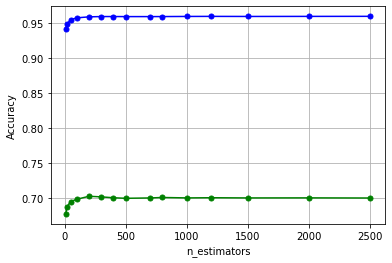

In [43]:
est_range = [10, 20, 50, 100, 200, 300, 400, 500, 700, 800, 1000, 1200, 1500, 2000, 2500]
plot_validation_curve(regressor, X_train, y_train, est_range, 'n_estimators')

In [78]:
param_grid = {
    'n_estimators': est_range
}


tuned_forest= GridSearchCV(regressor, param_grid, cv = 5, scoring='r2', verbose = 2, n_jobs=-1)
# perform search
tuned_forest.fit(X_train, y_train)

# best estimator
params = tuned_forest.best_params_

print(params)
print(tuned_forest.score(X_train,y_train))
print(tuned_forest.score(X_test,y_test))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.3min finished


{'n_estimators': 200}
0.9609113648579278
0.7450380046571629


What are the results for your chosen setup on the test set? 

In [79]:
print("Test set accuracy: {}".format(regressor.score(X_test, y_test)))
regressor = RandomForestRegressor(n_estimators = 200, random_state = 0)
regressor.fit(X_train, y_train)
print("Test set accuracy: {}".format(regressor.score(X_test, y_test)))

Test set accuracy: 0.7450380046571629
Test set accuracy: 0.7450380046571629


Compare your results for the random forest with those of the single decision tree and Bayesian Linear Regression, considering both performance and training time. Use a table or suitable plot to show the comparison and discuss the reasons for the differences.

In [81]:
from sklearn.metrics import r2_score

posterior_predictive_checks = pm.sample_posterior_predictive(trace, model=model, samples=1000, progressbar=True)
y_replicas = [y_rep.mean() for y_rep in posterior_predictive_checks['y']]  
predictions = np.mean(posterior_predictive_checks['y'], axis = 0)

def rsme(preds, targets):
    return np.sqrt(np.mean((preds-targets)**2))

print(y_test.shape)
print(np.array(y_replicas).shape)
print(predictions.shape)
#print(rsme(np.array(y_replicas), y_test))
print(r2_score(y_train, predictions))
print("Test set accuracy: {}".format(r2_score(y_test_full[0:1000], predictions)))
train_model_score = r2_score(y_train, predictions)
test_model_score = 0-r2_score(y_test_full[0:1000], predictions)

/home/karolina/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(200,)
(1000,)
(1000,)
0.5743889437819784
Test set accuracy: -0.572140922605592


Bayesian linear regression
Training set accuracy: 0.5743889437819784
Test set accuracy: 0.572140922605592
Decision tree regression
Training set accuracy: 0.7205282867057277
Test set accuracy: 0.6439054146296592
Random forest regression
Training set accuracy: 0.9609113648579278
Test set accuracy: 0.7450380046571629
treeraining time: 0.003537893295288086s
forest training time: 0.9047362804412842s


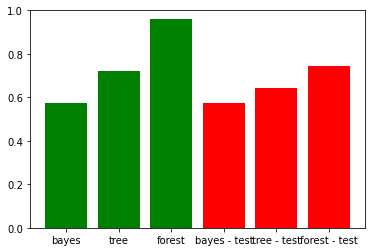

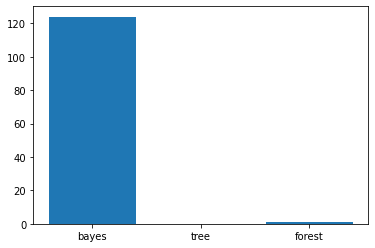

In [87]:
#might be wrong for bayes - very likely
print("Bayesian linear regression")
print("Training set accuracy: {}".format(train_model_score))
print("Test set accuracy: {}".format(test_model_score))
print("Decision tree regression")
print("Training set accuracy: {}".format(tree_model.score(X_train, y_train)))
print("Test set accuracy: {}".format(tree_model.score(X_test, y_test)))
print("Random forest regression")
print("Training set accuracy: {}".format(regressor.score(X_train, y_train)))
print("Test set accuracy: {}".format(regressor.score(X_test, y_test)))
x = np.array(['bayes', 'tree', 'forest'])
y = np.array([train_model_score, tree_model.score(X_train, y_train), regressor.score(X_train, y_train)])
xt = np.array(['bayes - test', 'tree - test', 'forest - test'])
yt = np.array([test_model_score, tree_model.score(X_test, y_test), regressor.score(X_test, y_test)])

import time
start = time.time()
tree_model.fit(X_train, y_train)
stop = time.time()
tree_time = stop-start
print(f"treeraining time: {stop - start}s")

start = time.time()
regressor.fit(X_train, y_train)
stop = time.time()
forest_time = stop-start
print(f"forest training time: {stop - start}s")
#what do I measure for time in bayes?
xcl = np.array(['bayes', 'tree', 'forest'])
ycl = np.array([bayes_time, tree_time, forest_time])


plt.bar(x, y, color = "green")
plt.bar(xt, yt, color = "red")
plt.ylim(0,1)
plt.show()

plt.bar(xcl, ycl)
#plt.ylim(0, 1)
plt.show()